In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
from utils_cellular_automata import *
from scipy.ndimage import label
import SimpleITK as sitk
from copy import copy
%matplotlib inline

In [2]:
def fig_multiple3D(ff, r=1, c=4, name='ff', vmin=0, vmax=1):
    '''Plot the middle slice of a 3D array.
    We assume that np.shape(ff) == B'''
    middle_slice = np.shape(np.squeeze(ff[0]))[0]//2 - 1
    fig, ax = plt.subplots(r,c, figsize=(c*2,r*2))
    for idx in range(r*c):
        if r <= 1:
            ax[idx].imshow(np.squeeze(ff[idx])[middle_slice,...])
        else:
            # print(idx,idx//c,idx%c)
            ax[idx//c,idx%c].imshow(np.squeeze(ff[idx])[middle_slice,...], vmin=vmin, vmax=vmax)
            # ax[idx//c,idx%c].text(5,10,f'{np.shape(ff[idx])}, {middle_slice}', color='y')
    for axx in ax.ravel(): axx.axis('off')
    # fig.suptitle(f'{name} {np.shape(ff)}')
    fig.tight_layout()

In [3]:
def fig_save_automata_growing(ID, idx, i, last32, orig32, vmin=0, vmax=1, folder='gifs/images_before_gifs/'):
    fig, ax = plt.subplots(1,3,figsize=(8.5,3))
    ax[0].imshow(last32[15], vmin=vmin, vmax=vmax)
    ax[0].text(2,2,'inpain',color='y', fontsize=12)
    ax[1].imshow(i, vmin=vmin, vmax=vmax)
    ax[1].text(2,2,f'cel aut {idx}',color='y', fontsize=12)
    ax[2].imshow(orig32[15], vmin=vmin, vmax=vmax)
    ax[2].text(2,2,'orig',color='y', fontsize=12)
    for axx in ax.ravel(): axx.axis('off')
    fig.tight_layout()
    plt.savefig(f'{folder}{ID}_{idx:04d}.png')
    plt.close()

In [4]:
def fig_read_figs_and_make_gif(ID, folder='gifs/images_before_gifs/'):
    files_figures = os.listdir(folder)
    files_figures = np.sort(files_figures)
    images_all = []
    for i in files_figures:
        a = imageio.mimread(f'{folder}{i}')
        os.remove(f'{folder}{i}')
        images_all.append(a[0])
    imageio.mimsave(f'gifs/{ID}.gif', images_all, duration=.3)

In [5]:
def pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x, cube_half_size = 40, xpad = 40):
    '''we padd the resampled image because some nodules are close to the border '''
    np_im_pad = np.pad(numpyImage_resampled_inserted,((xpad,xpad),(xpad,xpad),(xpad,xpad)),mode='reflect')
    cube_augmented = np_im_pad[coord_z-cube_half_size+xpad:coord_z+cube_half_size+xpad, coord_y-cube_half_size+xpad:coord_y+cube_half_size+xpad, coord_x-cube_half_size+xpad:coord_x+cube_half_size+xpad]
    assert np.shape(cube_augmented) == (80,80,80)
    return cube_augmented

In [6]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing

In [7]:
def resample_scan_sitk(image,spacing, original_shape, new_spacing=[1,1,1], resampling_method=sitk.sitkLinear):

    # reorder sizes as sitk expects them
    spacing_sitk = [spacing[1],spacing[2],spacing[0]]
    new_spacing_sitk = [new_spacing[1],new_spacing[2],new_spacing[0]]
    
    # set up the input image as at SITK image
    img = sitk.GetImageFromArray(image)
    img.SetSpacing(spacing_sitk)                
            
    # set up an identity transform to apply
    affine = sitk.AffineTransform(3)
    affine.SetMatrix(np.eye(3,3).ravel())
    affine.SetCenter(img.GetOrigin())
    
    # make the reference image grid, original_shape, with new spacing
    refImg = sitk.GetImageFromArray(np.zeros(original_shape,dtype=image.dtype))
    refImg.SetSpacing(new_spacing_sitk)
    refImg.SetOrigin(img.GetOrigin())
    
    imgNew = sitk.Resample(img, refImg, affine ,resampling_method, 0)
    
    imOut = sitk.GetArrayFromImage(imgNew).copy()
    
    return imOut

In [8]:
def insert_gan_image_in_no_segmented_lungs(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
    np.shape(numpyImage_resampled_block)
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
    assert np.sum(numpyImage_resampled_block == image_patched_denorm) > 1000
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x

In [9]:
def find_no_segmented_subfolder_and_read_it(file_one, data_candidates):
    '''find the corresponding subfolder of this image, read it and resample it'''
    # find the corresponding subfolder of this image
    name_original = file_one.split('_')[0] + '.mhd'
    data_dir_subsets = os.listdir(data_candidates)
    data_dir_subsets = [i for i in data_dir_subsets if 'subset' in i]
    data_dir_subsets = np.sort(data_dir_subsets)
    for sub in data_dir_subsets:
        if name_original in os.listdir(f'{data_candidates}{sub}'):
            break
    #read original (no-segmented) image
    numpyImage, numpyOrigin, numpySpacing = load_itk_image(f'{data_candidates}{sub}/{name_original}')
    # resample the image_without_segmentation
    new_spacing = [1,1,1]
    numpyImage_shape = ((np.shape(numpyImage) * numpySpacing) / np.asarray(new_spacing)).astype(int)
    numpyImage_resampled = resample_scan_sitk(numpyImage, numpySpacing, numpyImage_shape, new_spacing=new_spacing)
    return numpyImage_resampled, sub

In [10]:
def patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, ndl_grown):
    '''The only difference in v2 is that we do not pas ca_gen because we pass already one generation
    We patch the celullar-automata-generated (augen) nodule into the inpainted image (inpain)
    The extra mask (part2 < part5) is used to fix some dark spots visible in the patched image.
    This mask is formed by the values that are larger in the inpainted image than in the ca-generated
    image (looking only into the nodule-generated region)'''
    part1 = ((~mask_overlap).astype(int)*last32)
    part2 = ((mask_overlap).astype(int)*ndl_grown)
    part3 = (((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown))
    part4 = part2 > 0
    part5 = last32 * part4
    part6 = part2 < part5
    part7 = part2 < orig32*part4
    part8 = part2*(~part6) + last32*part6
    part9 = part2*(~part6) + last32*part6 + part1*(~part4)
    return part9, part4

In [11]:
def insert_gan_image_in_no_segmented_lungs2(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    break_flag = False
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
#     print(coord_z, coord_y, coord_x)
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
#     print(coord_z-size_half,coord_z+size_half, coord_y-size_half,coord_y+size_half, coord_x-size_half,coord_x+size_half)
#     print(np.shape(numpyImage_resampled_block))
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
#     print(np.sum(numpyImage_resampled_block == image_patched_denorm))
    if np.sum(numpyImage_resampled_block == image_patched_denorm) < 1000:
        errors.append(file_one)
        break_flag = True
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag

In [23]:
def insert_gan_image_in_no_segmented_lungs2_for_viz(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    break_flag = False
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
#     print(coord_z, coord_y, coord_x)
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
#     print(coord_z-size_half,coord_z+size_half, coord_y-size_half,coord_y+size_half, coord_x-size_half,coord_x+size_half)
#     print(np.shape(numpyImage_resampled_block))
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
#     print(np.sum(numpyImage_resampled_block == image_patched_denorm))
    if np.sum(numpyImage_resampled_block == image_patched_denorm) < 1000:
        errors.append(file_one)
        break_flag = True
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    numpyImage_resampled_block_orig = numpyImage_resampled_block
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag, numpyImage_resampled_block_orig

In [12]:
def fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, save=False, folder='gifs/check alignment from patch nodules v2B - loop/'):
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    ax[0,0].imshow(cube_augmented[39]); ax[0,0].text(2,6,'final', color='y', fontsize=14)
    ax[0,1].imshow(cube_augmented[39][24:56,24:56]); ax[0,1].text(2,2,'final (zoom)', color='y', fontsize=14)
    ax[1,0].imshow(patched_corrected[15]); ax[1,0].text(2,2,'cagen', color='y', fontsize=14)
    ax[1,1].imshow(orig32[15]); ax[1,1].text(2,2,'orig', color='y', fontsize=14)
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()
    if save:
        name_save = name_correct.split('.raw')[0] + '.png'
        plt.savefig(f'{folder}{name_save}')
        plt.close()

In [13]:
def fig_compare_masks_against_final_result(mask32, ca_gen, cube_augmented, mask_overlap, mask_ndl_grown, img_gen):
    mask32_profile = np.sum(mask32,(1,2))
    mask_ndl_grown_grown_profile = np.sum(mask_ndl_grown[ca_gen],(1,2))

    fig, ax = plt.subplots(1,8,figsize=(16,2))
    ax[0].imshow(cube_augmented[39])
    ax[1].imshow(cube_augmented[39][39-16: 39+16, 39-16: 39+16])
    ax[1].text(2,4, ca_gen, fontsize=14, color = 'y')
    ax[2].imshow(mask32[15])
    ax[2].text(2,4,'orig', fontsize=14, color = 'y')
    ax[3].imshow(mask_overlap[15])
    ax[3].text(2,4,'overlap', fontsize=14, color = 'y')
    ax[4].imshow(mask_ndl_grown[ca_gen][15])
    ax[4].text(2,4,'ndl_grown', fontsize=14, color = 'y')
    ax[5].imshow(img_gen[ca_gen][15])
    ax[6].plot(mask32_profile)
    ax[6].plot(mask_ndl_grown_grown_profile)
    ax[7].hist(cube_augmented[39][39-16: 39+16, 39-16: 39+16].flatten());
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
!pwd

In [ ]:
# 1. Make sure that nodules_sorted == nodules_sorted2
# path_drive = '/data/OMM/Datasets/Growing Celullar Automata Nodules/files in drive/'
## path_candidates = '/data/OMM/Datasets/LUNA/'
## path_dest = '/data/OMM/project results/Mar 02 20 - Cellular Automata Generated Images BATCH3/'

# nodules_sorted = np.load(f'{path_drive}nodules_sorted.npz')
# nodules_sorted2 = np.load(f'{path_drive}nodules_sorted2.npz')
# nodules_sorted = nodules_sorted.f.arr_0
# nodules_sorted2 = nodules_sorted2.f.arr_0

# # Make sure that nodules_sorted == nodules_sorted2
# for idx, (a,b) in enumerate(zip(nodules_sorted, nodules_sorted2)):
#     assert((a==b).all() == True)
#     if (a==b).all() == False: print(idx)
        
# # Delete large vars
# del nodules_sorted, nodules_sorted2

In [14]:
path_candidates = '/data/OMM/Datasets/LUNA/'
path_dest = '/data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_center/'

## 2. Check the indices of the nodules that were already grown with celullar automata

In [15]:
# FIRST BATCH
# Read nodules grown with automata
path_source = '/data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_center/'
files_all = os.listdir(path_source)
files_ndls = [i for i in files_all if 'npz' in i]
print(f'files after automata:\nfiles_all (include weights, names and images) = {len(files_all)},files_ndls = {len(files_ndls)}')
files_ndls_raw = [i.split('.npz')[0] for i in files_ndls]

# Reads files from sorting operation (these were the ones that were entered into the automata)
path_sorting = '/home/om18/Documents/KCL/Nov_27_19_cellular_automata/'
files_sorted = np.load(f'{path_sorting}files_sorted.npy')
files_ndls_sorted = np.load(f'{path_sorting}nodules_sorted2.npz')
files_ndls_sorted = files_ndls_sorted.f.arr_0
print(f'files before automata:\nfiles_sorted (names) = {len(files_sorted)}, files_ndls_sorted (images) = {len(files_ndls_sorted)}')

files after automata:
files_all (include weights, names and images) = 1612,files_ndls = 1611
files before automata:
files_sorted (names) = 2292, files_ndls_sorted (images) = 2292


In [ ]:
# GET ALL FILES WHERE THERE IS > 1 CONNECTED COMPONENTS (FUNCTION from COLAB)
assert 1==0
nodules_sorted = files_ndls_sorted
nodules_smaller = nodules_sorted
filenames_sorted = files_sorted
nodules_centered, names_centered = [], []
zs, ys, xs = [], [], []
for idx, (i, name) in tqdm_notebook(enumerate(zip(nodules_smaller, filenames_sorted)), total = len(nodules_smaller)):
    labelled, nr = label(i)
    if nr > 1: 
        m = i > 0
        zz,yy,xx = np.where(m==1)
        zzz = int(np.median(zz)); yyy = int(np.median(yy)); xxx = int(np.median(xx))
        ndl_centered = i[zzz-16:zzz+16, yyy-16:yyy+16, xxx-16:xxx+16]
        if np.shape(ndl_centered) == (32,32,32):
            nodules_centered.append(ndl_centered)
            names_centered.append(name)
            zs.append(zzz)
            ys.append(yyy)
            xs.append(xxx)
nodules_smaller = np.expand_dims(nodules_centered,1)
print(f'nodules_sorted = {np.shape(nodules_sorted)}, nodules_smaller = {np.shape(nodules_smaller)}')
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))

In [ ]:
# (DO NOT USE) CODE FROM COLAB FOR PAPER
assert 1==0
nodules_sorted = np.load('/content/gdrive/My Drive/KCL/cellular automata v2/nodules_sorted3.npz')
filenames_sorted = np.load('/content/gdrive/My Drive/KCL/cellular automata v2/files_sorted3.npy')
#nodules_sorted = np.load('/home/om18/Documents/KCL/Nov_27_19_cellular_automata/nodules_sorted.npz')
nodules_sorted = nodules_sorted.f.arr_0
# For now work only with 32x32x32
nodules_smaller = nodules_sorted[:,16:-16, 16:-16, 16:-16]
# only use those images that include only 1 nodule
nodules_centered, names_centered = [], []
for i, name in zip(nodules_smaller, filenames_sorted):
    labelled, nr = label(i)
    if nr == 1:
      nodules_centered.append(i)
      names_centered.append(name)
nodules_smaller = np.expand_dims(nodules_centered,1)
print(f'nodules_sorted = {np.shape(nodules_sorted)}, nodules_smaller = {np.shape(nodules_smaller)}')
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))

fig_multiple3D(nodules3D[1610:],r=4,c=4,name='nodules 1400')

In [16]:
# Jun 2020
nodules_sorted = files_ndls_sorted
nodules_smaller = nodules_sorted[:,16:-16, 16:-16, 16:-16] # For now work only with 32x32x32
filenames_sorted = files_sorted
nodules_centered, names_centered = [], []
zs, ys, xs = [], [], []
for idx, (i, name) in tqdm_notebook(enumerate(zip(nodules_smaller, filenames_sorted)), total = len(nodules_smaller)):
    labelled, nr = label(i)
    if nr == 1:
        nodules_centered.append(i)
        names_centered.append(name)
nodules_smaller = np.expand_dims(nodules_centered,1)
print(f'nodules_sorted = {np.shape(nodules_sorted)}, nodules_smaller = {np.shape(nodules_smaller)}')
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))


nodules_sorted = (2292, 64, 64, 64), nodules_smaller = (1657, 1, 32, 32, 32)
(1657, 32, 32, 32, 1)


total_images_analyzed (in the subset of BATCH3) = 102


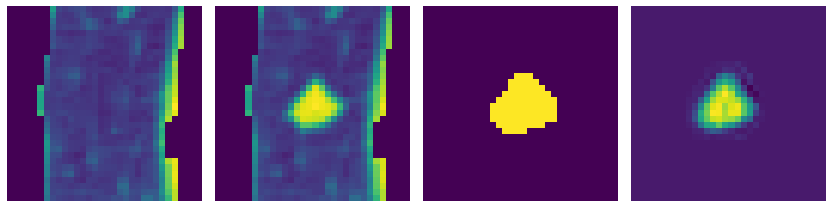

In [182]:
# From 1 image used in (BATCH3) get the corresponding inpain and orig
print(f'total_images_analyzed (in the subset of BATCH3) = {len(path_source)}')
# idx = 12 # 1, 12, 16, 18, 25, 27, 28, 30, 32, 37, 41, 43, 46, 47, 48, 51, 61, 71, 96, 103, 104, 109, 123
idx = 96
fbatch3 = os.listdir(path_source)
fbatch3 = [i for i in fbatch3 if '.npz' in i]
name_correct = fbatch3[idx]
img_gen = np.load(f'{path_source}{name_correct}')
img_gen = img_gen.f.arr_0
# Get the images used in inpainting
path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
# print(f'zs = {zs[idx]}, ys = {ys[idx]}, xs = {xs[idx]}') #INCLUDE_COORDS
# ===
fig, ax = plt.subplots(1,4,figsize=(12,3))
ax[0].imshow(last32[15])
ax[1].imshow(orig32[15])
ax[2].imshow(mask32[15])
ax[3].imshow(img_gen[80][15])
for axx in ax.ravel(): axx.axis('off'); plt.tight_layout() 


In [ ]:
# USE IN THE VERSION WHERE COORDINATES ARE NEEDED
# Get the coords used to center the nodule using the name
assert 1==0
for idx, i in enumerate(names_centered):
    if i == name_correct.split('.npz')[0]:
        idx_coords = idx
        print(idx_coords, i)
print(f'zs = {zs[idx_coords]}, ys = {ys[idx_coords]}, xs = {xs[idx_coords]}')

In [ ]:
name_correct, coord_z, coord_y, coord_x

In [34]:
# PLOT ONE IMAGE
# load the file where you want to patch this image
# Read original CT image (not even segmented)
ndl_grown = img_gen[40]
mask_ndl_grown = ndl_grown > 0
numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
mask_overlap  = np.logical_and(mask_ndl_grown, mask32)
patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, ndl_grown)

# Insert generated image into original CT image,  (The coords of the nodule are in its name) 
numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)

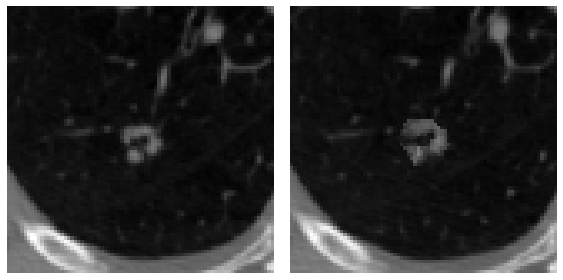

In [198]:
coord_z = int(name_correct.split('_z')[-1].split('y')[0]);coord_y = int(name_correct.split('y')[-1].split('x')[0]);coord_x = int(name_correct.split('x')[-1].split('.')[0])
szViz = 40
fig, ax  =plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(numpyImage_resampled[coord_z][coord_y-szViz:coord_y+szViz,coord_x-szViz:coord_x+szViz], cmap='gray')
ax[1].imshow(cube_augmented[39], cmap='gray')
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
# NEW
SAVE_FIGS = 40
gen_range = np.arange(100)
FILES = os.listdir(path_source)
FILES = [i for i in FILES if '.npz' in i]
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
for idx, name_correct in tqdm_notebook(enumerate(FILES), total=len(FILES)):
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    mask_ndl_grown = img_gen > 0
    # 
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen[ca_gen])
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        # insert_gan_image_in_no_segmented_lungs3 was used for components > 1
#         numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs3(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) 
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            name_correcr_modified = name_correct.split('.raw')[0]
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correcr_modified}_epA{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - img_gen[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, True)
    
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

In [202]:
# MAKE GIF FOR VIZ
fbatch3 = os.listdir(path_source)
fbatch3 = [i for i in fbatch3 if '.npz' in i]
path_figs = 'figures_automata/'
path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
ids_chosen = [1, 12, 16, 18, 25, 27, 28, 30, 32, 37, 41, 43, 46, 47, 48, 51, 61, 71, 96, 103, 104, 109, 123]
for idx, ndl_idx in tqdm_notebook(enumerate(ids_chosen), total=len(ids_chosen)):
#     if idx==2:break
    name_correct = fbatch3[ndl_idx]
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    # load the file where you want to patch this image
    # Read original CT image (not even segmented)

    for ii in tqdm_notebook(range(len(img_gen)),leave=False):
        ndl_grown = img_gen[ii]
        mask_ndl_grown = ndl_grown > 0
        numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
        mask_overlap  = np.logical_and(mask_ndl_grown, mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, ndl_grown)

        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
#         #fig1    
#         plt.imshow(cube_augmented[39], cmap='gray')
#         plt.axis('off')
        #fig2
        coord_z = int(name_correct.split('_z')[-1].split('y')[0]);coord_y = int(name_correct.split('y')[-1].split('x')[0]);coord_x = int(name_correct.split('x')[-1].split('.')[0])
        szViz = 40
        fig, ax  =plt.subplots(1,2,figsize=(8,4))
        ax[0].imshow(numpyImage_resampled[coord_z][coord_y-szViz:coord_y+szViz,coord_x-szViz:coord_x+szViz], cmap='gray')
        ax[1].imshow(cube_augmented[39], cmap='gray')
        for axx in ax.ravel(): axx.axis('off')
        fig.tight_layout()
        
        plt.savefig(f'{path_figs}nodule_{ii:03d}.jpg')
        plt.close()
    
    files_figures = os.listdir(path_figs)
    files_figures = [i for i in files_figures if '.jpg' in i]
    files_figures = np.sort(files_figures)
    images_all = []
    for idx, i in enumerate(files_figures):

        one_fig = imageio.mimread(f'{path_figs}{i}')[0]
        os.remove(f'{path_figs}{i}')
        images_all.append(one_fig)
    new_name = name_correct.split(".raw")[0]
    imageio.mimsave(f'{path_figs}gifs/tg{new_name}.gif', images_all, duration=.1)

In [204]:
!ls figures_automata/gifs

1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428_block2_0_z203y246x228.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545_block2_0_z117y220x261.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676008763729469324839_block1_0_z302y206x109.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053_block2_0_z112y97x263.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421_block1_10_z151y89x87.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125_block1_210_z195y236x122.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074_block1_32_z199y114x196.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.217754016294471278921686508169_block1_10_z132y136x64.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332_block1_0_z187y198x123.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.241717018262666382493757419144_block2_1_z217y268x257.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.259227883564429312164962953756_block1_0_z203y176x127.gi

In [ ]:
# load the file where you want to patch this image
# Read original CT image (not even segmented)

for ii in tqdm_notebook(range(len(img_gen))):
    ndl_grown = img_gen[ii]
    mask_ndl_grown = ndl_grown > 0
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    mask_overlap  = np.logical_and(mask_ndl_grown, mask32)
    patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, ndl_grown)

    # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
    numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
    cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
    plt.imshow(cube_augmented[39])
    plt.axis('off')
    plt.savefig(f'{path_figs}nodule_{ii:03d}.jpg')
    plt.close()

In [ ]:
files_figures = os.listdir(path_figs)
files_figures = [i for i in files_figures if '.jpg' in i]
files_figures = np.sort(files_figures)
images_all = []
for idx, i in enumerate(files_figures):
    
    one_fig = imageio.mimread(f'{path_figs}{i}')[0]
    os.remove(f'{path_figs}{i}')
    images_all.append(one_fig)
new_name = name_correct.split(".raw")[0]
imageio.mimsave(f'{path_figs}gifs/{new_name}.gif', images_all, duration=.1)

In [ ]:
!ls -t figures_automata/gifs/

In [ ]:
# NEW
SAVE_FIGS = 40
gen_range = np.arange(100)
fbatch3 = os.listdir(path_source)
fbatch3 = [i for i in fbatch3 if '.npz' in i]
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
for idx, name_correct in tqdm_notebook(enumerate(fbatch3), total=len(fbatch3)):
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    mask_ndl_grown = img_gen > 0
    # 
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen[ca_gen])
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs3(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            name_correcr_modified = name_correct.split('.raw')[0]
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correcr_modified}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - img_gen[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, True)
    
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

In [ ]:
name_correct.split('.raw')[0]

In [ ]:
print(name_correct)
print(name_correct[:-4])
print(name_correct.split('.raw')[0])

In [ ]:
# OLD (March 9th morning)
SAVE_FIGS = 40
gen_range = np.arange(100)
fbatch3 = os.listdir(path_source)
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
for idx, name_correct in enumerate(fbatch3):
    aaa=1
    if idx<aaa: continue
    if idx==aaa+1:break
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    mask_ndl_grown = [i > 0 for i in ndl_grown]
    # 
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown, mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen[ca_gen])
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correct[:-4]}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - img_gen[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, True)
    
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

In [ ]:
SAVE_FIGS = 40
gen_range = np.arange(100)
fbatch3 = os.listdir(path_source)
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
for idx, name_correct in enumerate(fbatch3):
    aaa = 9
    if idx<aaa: continue
    if idx==aaa+1:break
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    mask_ndl_grown = img_gen > 0
    # 
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen[ca_gen])
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs3(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False: os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            if ca_gen % 4 ==0:
                fig_compare_masks_against_final_result(mask32, ca_gen, cube_augmented, mask_overlap, mask_ndl_grown, img_gen)
                
        loss_new = np.mean((orig32*mask32 - img_gen[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    

In [ ]:
ca_gen

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].imshow(last32[15])
ax[1].imshow(orig32[15])
ax[2].imshow(cube_augmented[39][39-16: 39+16, 39-16: 39+16])
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
np.shape(numpyImage_resampled_inserted)

In [ ]:
offset_ = 10
fig, ax = plt.subplots(1,3, figsize=(12,2))
ax[0].imshow(cube_augmented[39][39-offset_: 39+offset_, 39-offset_: 39+offset_])
ax[0].imshow(cube_augmented[39][39-offset_: 39+offset_, 39-offset_: 39+offset_]<=-960)
ax[1].hist(cube_augmented[39][39-offset_: 39+offset_, 39-offset_: 39+offset_].flatten());

In [ ]:
print(np.shape(cube_augmented), 80**3, 6884**(1/3))
z_correction, y_correction, x_correction = np.where(cube_augmented < -960)

len(z_correction)

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(12,2))
ax[0].imshow(last32[15])
ax[1].imshow(orig32[15])
ax[2].imshow(cube_augmented[39][39-16: 39+16, 39-16: 39+16])
ax[3].imshow(mask_overlap[15])
ax[3].text(2,4,'overlap', fontsize=14, color = 'y')
ax[4].imshow(patched_corrected[15])
ax[4].text(2,8,'patched_\ncorrected', fontsize=14, color = 'y')
ax[5].imshow(numpyImage_resampled_inserted[coord_z][coord_y-15:coord_y+15, coord_x-15:coord_x+15])
# ax[5].text(2,6.5,'resampled_\ninserted', fontsize=14, color = 'y')
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask_overlap) # WARNING mask32 or mask_overlap?

In [ ]:
def insert_gan_image_in_no_segmented_lungs3(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    break_flag = False
    THRESHOLD_CORRECTION = -960
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
#     print(coord_z, coord_y, coord_x)
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
#     print(coord_z-size_half,coord_z+size_half, coord_y-size_half,coord_y+size_half, coord_x-size_half,coord_x+size_half)
#     print(np.shape(numpyImage_resampled_block))
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
#     print(np.sum(numpyImage_resampled_block == image_patched_denorm))
    if np.sum(numpyImage_resampled_block == image_patched_denorm) < 1000:
        errors.append(file_one)
        break_flag = True
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    zz,yy,xx = np.where(image_patched_denorm > -960)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # Correction v3
    z_correction, y_correction, x_correction = np.where(image_patched_denorm < THRESHOLD_CORRECTION)
    numpyImage_resampled_block[z_correction, y_correction, x_correction]
    
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    
#     zz_correction, yy_correction, xx_correction = np.where(numpyImage_resampled_inserted < -THRESHOLD_CORRECTION)
#     numpyImage_resampled_inserted[zz_correction, yy_correction, xx_correction] = numpyImage_resampled[zz_correction, yy_correction, xx_correction]
    
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag

In [ ]:
zz,yy,xx = np.where(mask_overlap==1)
print(zz[:10],yy[:10],xx[:10])
zz2 = zz + zs[idx_coords]-39; yy2 = yy + ys[idx_coords]-39; xx2 = xx + xs[idx_coords]-39;
print(zz2[:10],yy2[:10],xx2[:10])

In [ ]:
print(np.shape(patched_corrected))
plt.imshow(patched_corrected[15])

In [ ]:
plt.imshow(numpyImage_resampled[coord_z][coord_y-15:coord_y+15, coord_x-15:coord_x+15])

In [ ]:
for idx, i in enumerate(mask_ndl_grown):
    print(idx, np.sum(i))

In [ ]:
for idx, i in enumerate(names_centered):
    if i == name_correct.split('.npz')[0]:
        idx_coords = idx
        print(idx_coords, i)
print(f'zs = {zs[idx_coords]}, ys = {ys[idx_coords]}, xs = {xs[idx_coords]}')

In [ ]:
ppp = '/data/OMM/project results/Mar 02 20 - Cellular Automata Generated Images BATCH3/patched/subset7/'
ff = os.listdir(ppp)
ff= np.sort(ff)
for idx, i in enumerate(ff):
    a = np.fromfile(ppp+i,dtype='int16').astype('float32').reshape((80,80,80))
    if idx==10:break
    plt.figure()
    plt.imshow(a[39])

In [ ]:
for idx, i in enumerate(img_gen):
    if idx==10: break
    fig, ax = plt.subplots(1,4, figsize=(12,3))
    ax[0].imshow(i[15])
    ax[1].imshow(mask32[15])
    ax[2].imshow(orig32[15])
    ax[3].imshow((ndl_grown[idx]*mask32)[15])
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
plt.imshow(ndl_grown[8])

In [ ]:
np.shape(ndl_grown)

In [ ]:
plt.plot(mseloss)

In [ ]:
for idx, i in enumerate(ff[-10:]):
    a = np.fromfile(ppp+i,dtype='int16').astype('float32').reshape((80,80,80))
    if idx==10:break
    plt.figure()
    plt.imshow(a[39])

In [ ]:
# With correction
offset_ndl = 0
SAVE_FIGS = 40
gen_range = np.arange(100)
# gen_range = np.arange(20,200,3)
generations_multi = []
mselosses, min_losses, min_losses_idx = [], [], []
errors=[]
for idx, name_wrong in tqdm_notebook(enumerate(dict_names.keys()), total=len(dict_names.keys())):
    if idx<offset_ndl: continue
#     if idx==offset_ndl+1: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    
    mseloss = []
    min_loss = 1
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
        
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        # padd resampled image (some nodules are close to border) 
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correct[:-4]}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - ndl_grown[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
        
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

## 3. Fixing an error with the names given to the automata output

In [ ]:
# Previously we were getting the nodules where label_nr == 1 BUT we were not making any modification
# to files_sorted. Now we also modify that variable -> files_sorted_centered
nodules_smaller = files_ndls_sorted[:,16:-16, 16:-16, 16:-16]
print(len(files_sorted), len(files_ndls_sorted), np.shape(nodules_smaller[0]))
nodules_centered = []
files_sorted_centered, files_excluded = [], []
for idx, i in enumerate(nodules_smaller):
    labelled, nr = label(i)
    if nr == 1: 
        nodules_centered.append(i)
        files_sorted_centered.append(files_sorted[idx]) # <-- this line was not included
    else:
        files_excluded.append(files_sorted[idx])
nodules_smaller2 = np.expand_dims(nodules_centered,1)
print(len(nodules_smaller2), len(files_sorted_centered), np.shape(nodules_smaller2[0]))
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller2]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
# fig_multiple3D(nodules3D[1610:],r=4,c=4,name='nodules 1400')

In [ ]:
# 1. Track back the nodules that were already grown
# First get the indices of the nodules that were already grown by the celullar automata.
# Those indices are from the list constructed with only those nodules where (label_nr == 1).
# When that list was constructed a separate list with their corresponding names was not constructed, and
# the grown files are getting an INCORRECT name from the list with ALL names
files_sorted2_zeros = np.zeros_like(files_sorted)
idx_ndl_grown = []
for idx, i in enumerate(files_sorted):
    if i in files_done:
        idx_ndl_grown.append(idx)
files_sorted2_zeros[np.asarray(idx_ndl_grown)] = 1
plt.figure(figsize=(16,2))
plt.plot(files_sorted2_zeros);

In [ ]:
# 1.5 We might need to center back the nodule
# When the only-nodules dataset was created we centered the nodule using
# z_min, y_min, x_min, z_max, y_max, x_max, z_len, y_len, x_len. x_min and x_max are the min and max coord of the
# nodule in one axis. amd x_len is the length of the nodule in that axis
zyx = np.load('zyx_min_max_len_sorted.npy')

In [ ]:
# Track back the nodules that were already grown
# 2. We can use those indices to trace back the correct name of grown nodules.
files_sorted2_zeros = np.squeeze(np.zeros((1,len(files_sorted))))
idx_ndl_traced_back = []
names_correct = []
zyx_correct = []
for idx, i in enumerate(files_sorted):
    if i in np.asarray(files_sorted_centered)[idx_ndl_grown]:
        idx_ndl_traced_back.append(idx)
        names_correct.append(i)
        zyx_correct.append(zyx[idx])
files_sorted2_zeros[np.asarray(idx_ndl_traced_back)] = 1
plt.figure(figsize=(16,2))
plt.plot(files_sorted2_zeros);
print(len(files_sorted), len(idx_ndl_traced_back), len(zyx_correct))

In [ ]:
# Track back the nodules that were already grown
# 2. We can use those indices to trace back the correct name of grown nodules.
files_sorted2_zeros = np.squeeze(np.zeros((1,len(files_sorted))))
idx_ndl_traced_back = []
names_correct = []
zyx_correct = []
for idx, i in enumerate(files_sorted):
    if i in np.asarray(files_sorted_centered)[idx_ndl_grown]:
        idx_ndl_traced_back.append(idx)
        names_correct.append(i)
        zyx_correct.append(zyx[idx])
files_sorted2_zeros[np.asarray(idx_ndl_traced_back)] = 1
plt.figure(figsize=(16,2))
plt.plot(files_sorted2_zeros);
print(len(files_sorted), len(idx_ndl_traced_back), len(zyx_correct))

In [ ]:
plt.figure(figsize=(16,2))
plt.plot(files_sorted2_zeros);

In [ ]:
len(files_done)

In [ ]:
# 3. Make a dictionary that maps the incorrect to the correct name
dict_names = dict(zip(files_done, names_correct))
dict_zyx = dict(zip(files_done, zyx_correct))
name_wrong = files_done[-1]
name_correct = dict_names.get(name_wrong)
name_correct_zyx = dict_zyx.get(name_wrong)
print(name_wrong) # OLD (incorrect)
print(name_correct) # NEW (correct)
print(name_correct_zyx)

## 4. Fix some dark spots visible in the patched image.

In [ ]:
def patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen):
    '''We patch the celullar-automata-generated (augen) nodule into the inpainted image (inpain)
    The extra mask (part2 < part5) is used to fix some dark spots visible in the patched image.
    This mask is formed by the values that are larger in the inpainted image than in the ca-generated
    image (looking only into the nodule-generated region)'''
    part1 = ((~mask_overlap).astype(int)*last32)
    part2 = ((mask_overlap).astype(int)*ndl_grown[ca_gen])
    part3 = (((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen]))
    part4 = part2 > 0
    part5 = last32 * part4
    part6 = part2 < part5
    part7 = part2 < orig32*part4
    part8 = part2*(~part6) + last32*part6
    part9 = part2*(~part6) + last32*part6 + part1*(~part4)
    return part9, part4

In [ ]:
path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
files = os.listdir(f'{path_data}original/')
print(f'total files = {len(files)}')
print(name_correct)

In [ ]:
# Without correction
offset_ndl = 200
ca_gen = 50
for idx, name_wrong in enumerate(dict_names.keys()):
    if idx<=offset_ndl: continue
    if idx==offset_ndl+10: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
    patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
    fig, ax = plt.subplots(1,6, figsize=(18,3));
    ax[0].imshow(last32[15], vmin=0, vmax=1); 
    ax[1].imshow(orig32[15], vmin=0, vmax=1); 
    ax[2].imshow(mask32[15], vmin=0, vmax=1)
    ax[3].imshow(ndl_grown[ca_gen][15], vmin=0, vmax=1)
    ax[4].imshow(patched[15], vmin=0, vmax=1)
    ax[5].imshow(mask_ndl_grown[ca_gen][15] + mask32[15], vmin=0, vmax=2)
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
# With correction
offset_ndl = 200
ca_gen = 50
for idx, name_wrong in enumerate(dict_names.keys()):
    if idx<=offset_ndl: continue
    if idx==offset_ndl+10: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
    patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
    patched_corrected, _ = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
    fig, ax = plt.subplots(1,6, figsize=(18,3));
    ax[0].imshow(last32[15], vmin=0, vmax=1); 
    ax[1].imshow(orig32[15], vmin=0, vmax=1); 
#     ax[2].imshow(mask32[15], vmin=0, vmax=1)
    ax[2].imshow(ndl_grown[ca_gen][15], vmin=0, vmax=1)
    ax[3].imshow(patched[15], vmin=0, vmax=1)
    ax[4].imshow(patched_corrected[15], vmin=0, vmax=1)
    ax[5].imshow(mask_ndl_grown[ca_gen][15] + mask32[15], vmin=0, vmax=2)
    
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

# 5. Patch the nodule grown with celullar automata in the inpainted image  

In [ ]:
def find_no_segmented_subfolder_and_read_it(file_one, data_candidates):
    '''find the corresponding subfolder of this image, read it and resample it'''
    # find the corresponding subfolder of this image
    name_original = file_one.split('_')[0] + '.mhd'
    data_dir_subsets = os.listdir(data_candidates)
    data_dir_subsets = [i for i in data_dir_subsets if 'subset' in i]
    data_dir_subsets = np.sort(data_dir_subsets)
    for sub in data_dir_subsets:
        if name_original in os.listdir(f'{data_candidates}{sub}'):
            break
    #read original (no-segmented) image
    numpyImage, numpyOrigin, numpySpacing = load_itk_image(f'{data_candidates}{sub}/{name_original}')
    # resample the image_without_segmentation
    new_spacing = [1,1,1]
    numpyImage_shape = ((np.shape(numpyImage) * numpySpacing) / np.asarray(new_spacing)).astype(int)
    numpyImage_resampled = resample_scan_sitk(numpyImage, numpySpacing, numpyImage_shape, new_spacing=new_spacing)
    return numpyImage_resampled, sub

In [ ]:
for aaa in range(5):
    for bbb in np.arange(5):
        if bbb==2:break
        print(aaa, bbb)
        

In [ ]:
# With correction
offset_ndl = 0
SAVE_FIGS = 40
gen_range = np.arange(100)
# gen_range = np.arange(20,200,3)
generations_multi = []
mselosses, min_losses, min_losses_idx = [], [], []
errors=[]
for idx, name_wrong in tqdm_notebook(enumerate(dict_names.keys()), total=len(dict_names.keys())):
    if idx<offset_ndl: continue
#     if idx==offset_ndl+1: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    
    mseloss = []
    min_loss = 1
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
        
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        # padd resampled image (some nodules are close to border) 
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correct[:-4]}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - ndl_grown[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
        
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

In [ ]:
path_dest = '/data/OMM/project results/Mar 02 20 - Cellular Automata Generated ImagesDELETE/'

In [ ]:
# With correction
offset_ndl = 0
SAVE_FIGS = 40
gen_range = np.arange(100)
# gen_range = np.arange(20,200,3)
generations_multi = []
mselosses, min_losses, min_losses_idx = [], [], []
errors=[]
for idx, name_wrong in tqdm_notebook(enumerate(dict_names.keys()), total=len(dict_names.keys())):
    if idx<offset_ndl: continue
#     if idx==offset_ndl+1: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    
    mseloss = []
    min_loss = 1
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
        
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        # padd resampled image (some nodules are close to border) 
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
#         if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
#             os.makedirs(f'{path_dest}patched/{subfolder_save}')
#         if ca_gen >= 2: #skip first two generations
#             cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correct[:-4]}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - ndl_grown[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
#         mseloss.append(loss_new) 

        # save a few ID for gif
#         if idx % SAVE_FIGS == 0:
#             fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
#     min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
        
#     if idx % SAVE_FIGS == 0:
#         fig_read_figs_and_make_gif(name_correct) # Make GIF

In [ ]:
def insert_gan_image_in_no_segmented_lungs2(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    break_flag = False
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
#     print(coord_z, coord_y, coord_x)
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
#     print(coord_z-size_half,coord_z+size_half, coord_y-size_half,coord_y+size_half, coord_x-size_half,coord_x+size_half)
#     print(np.shape(numpyImage_resampled_block))
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
#     print(np.sum(numpyImage_resampled_block == image_patched_denorm))
    if np.sum(numpyImage_resampled_block == image_patched_denorm) < 1000:
        errors.append(file_one)
        break_flag = True
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag

In [ ]:
238-206, 241-209, 218-186 

In [ ]:
len(dict_names.keys())

In [ ]:
padxx = 12
print(np.shape(patched_corrected))
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(numpyImage_resampled[coord_z][coord_y-padxx:coord_y+padxx, coord_x-padxx:coord_x+padxx])
ax[1].imshow(numpyImage_resampled_inserted[coord_z][coord_y-padxx:coord_y+padxx, coord_x-padxx:coord_x+padxx])
ax[2].imshow(np.abs(numpyImage_resampled[coord_z][coord_y-padxx:coord_y+padxx, coord_x-padxx:coord_x+padxx] - numpyImage_resampled_inserted[coord_z][coord_y-padxx:coord_y+padxx, coord_x-padxx:coord_x+padxx]))
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
import sys

In [ ]:
path_xx = '/data/OMM/project results/Mar 02 20 - Cellular Automata Generated Images/patched/subset5/'
ff = os.listdir(path_xx)
ff = np.sort(ff)
for idx, i in enumerate(ff):
    if idx==10:break
    a = np.fromfile(f'{path_xx}{i}',dtype='int16').astype('float32').reshape((80,80,80))
    print(sys.getsizeof(a))
    plt.figure()
    plt.hist(a.flatten());

In [ ]:
a = np.fromfile(f'{pathxx}{i}',dtype='float').astype('float32').reshape((80,80,80))

In [ ]:
pathxx = '/media/om18/45c77682-c907-4971-84d4-126ad0d801dc2/LUNA16/cycleGAN_aug_10_folds/subset0/'
ff = os.listdir(pathxx)
for idx, i in enumerate(ff):
    if idx==10:break
    a = np.fromfile(f'{pathxx}{i}',dtype='int16').astype('float32').reshape((80,80,80))
    print(sys.getsizeof(a))
    plt.figure()
    plt.hist(a.flatten());

In [ ]:
# In more detail:
# We patch the celullar-automata-generated (augen) nodule into the inpainted image (inpain)
x=2; y=4
part1 = ((~mask_overlap).astype(int)*last32)
part2 = ((mask_overlap).astype(int)*ndl_grown[ca_gen])
part3 = (((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen]))
part4 = part2 > 0
part5 = last32 * part4
part6 = part2 < part5
part7 = part2 < orig32*part4
part8 = part2*(~part6) + last32*part6
part9 = part2*(~part6) + last32*part6 + part1*(~part4)
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0,0].imshow(part1[15]); ax[0,0].text(x, y, 'inpain no augen', color='y', fontsize=14)
ax[0,1].imshow(part2[15]); ax[0,1].text(x, y, 'augen', color='y', fontsize=14)
ax[0,2].imshow(part3[15]); ax[0,2].text(x, y, 'inpain + augen [3]', color='y', fontsize=14)
ax[1,0].imshow(part4[15]); ax[1,0].text(x, y, 'augen mask', color='y', fontsize=14)
ax[1,1].imshow(part5[15]); ax[1,1].text(x, y, 'inpain * augen mask [5]', color='y', fontsize=14)
ax[1,2].imshow(part6[15]); ax[1,2].text(x, y, '(augen < inpain) \n* augen mask [6]', color='y', fontsize=14)
ax[2,0].imshow(part3[15]); ax[2,0].text(x, y, '3+6', color='y', fontsize=14)
ax[2,0].imshow(part6[15], alpha=.3)
ax[2,1].imshow(part8[15]); ax[2,1].text(x, y, 'augen * ~6 +\ninpain *  6 [8]', color='y', fontsize=14)
ax[2,2].imshow(part9[15]); ax[2,2].text(x, y, '8 + 1', color='y', fontsize=14)

for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
# With correction
offset_ndl = 200
SAVE_FIGS = 400
gen_range = np.arange(100)
# gen_range = np.arange(20,200,3)
generations_multi = []
mselosses, min_losses, min_losses_idx = [], [], []
for idx, name_wrong in tqdm_notebook(enumerate(dict_names.keys()), total=len(dict_names.keys())):
    if idx<=offset_ndl: continue
    if idx==offset_ndl+20: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    
    generations = []
    mseloss = []
    min_loss = 1
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
        loss_new = np.mean((orig32*mask32 - ndl_grown[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 
#         if mseloss
        
        
        generations.append(patched_corrected)
        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
        
    generations_multi.append(generations)
    mselosses.append(mseloss)
    
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF
    
    
    
    

In [ ]:
for i in np.arange(1,1161):
    if 65536 **(1/(i**3)) %1 ==0:
        print(i)

In [ ]:
# check previous format: read augmented data from cycleGAN 
path_augmented_data = '/media/om18/45c77682-c907-4971-84d4-126ad0d801dc2/LUNA16/cycleGAN_aug_10_folds/subset0/'
ffA = os.listdir(path_augmented_data)
a = np.fromfile(f'{path_augmented_data}{ffA[0]}',dtype='int16').astype('float32').reshape((80,80,80))
print(np.shape(a))

In [ ]:
# check previous format: read augmented data from cycleGAN 
path_augmented_data = '/data/OMM/project results/Feb 20 19 - CycleGan clean/deep nodule prior luna v2 - cubes size 32 coefficients/images augmented/patched/subset0/'
ffA = os.listdir(path_augmented_data)
a = np.fromfile(f'{path_augmented_data}{ffA[0]}',dtype='int16').astype('float32').reshape((80,80,80))
print(np.shape(a))

In [ ]:
plt.imshow(a[40])

In [ ]:
a = np.fromfile(f'{path_augmented_data}{ffA[0]}',dtype='int16').astype('float32')
print(np.shape(a))


In [ ]:
a = np.fromfile(f'{path_augmented_data}{ffA[0]}',dtype='int16').astype('float32').reshape((80,80,80))
np.shape(a)

In [ ]:
plt.hist(min_losses_idx);

In [ ]:
for idx, (loss, min_value, min_idx) in enumerate(zip(mselosses, min_losses, min_losses_idx)):
    if idx==16:
        plt.plot(loss, c='#1133AA', alpha=.3)
        plt.scatter(min_idx, min_value, c='#1133AA')
        ax = plt.gca(); ax.set_yscale('log')

In [ ]:
for idx, (loss, min_value, min_idx) in enumerate(zip(mselosses[16:], min_losses[16:], min_losses_idx[16:])):
    if idx==0:
        plt.plot(loss[40:], c='#1133AA', alpha=.3)
        plt.scatter(np.asarray(min_idx)[40:], np.asarray(min_value)[40:], c='#1133AA')
        ax = plt.gca(); ax.set_yscale('log')

In [ ]:
for loss, min_value, min_idx in zip(mselosses, min_losses, min_losses_idx):
    plt.plot(loss, c='#1133AA', alpha=.3)
    plt.scatter(min_idx, min_value, c='#1133AA', alpha=.8)

In [ ]:
xx = []
for i in generations_multi[2]:
    xx.append(np.mean((orig32*mask32 - i*mask32)**2))
plt.semilogy(xx)

In [ ]:
xx = []
for i in ndl_grown[:100]:
    xx.append(np.mean((orig32*mask32 - i*mask32)**2))
plt.semilogy(xx)

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow((orig32*mask32)[15])
ax[1].imshow((generations[0]*mask32)[15])
np.median(((orig32*mask32) - (patched_corrected*mask32))**2)

In [ ]:
print(files_sorted[0])
a = np.load('/home/om18/Downloads/files_sorted_maybe_old.npy')
a[0]

In [ ]:
print(np.shape(orig32), np.shape(mask32), np.shape(patched_corrected))
fig, ax = plt.subplots(1,2)
ax[0].imshow((orig32*mask32)[15])
ax[1].imshow((patched_corrected*mask32)[15])
np.mean(((orig32*mask32) - (patched_corrected*mask32))**2)

In [ ]:
for idx, name_wrong in enumerate(dict_names.keys()):
    if idx<=offset_ndl: continue
    if idx==offset_ndl+4: break
    name_correct = dict_names.get(name_wrong)
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    plt.figure()
    plt.imshow(orig[31])
    print(name_correct)

In [ ]:
a1 = '1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084_block2_0_z105y172x259.raw'
a2 = '1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537_block1_10_z341y133x83.raw'
a3 = '1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_block2_432_z225y165x272.raw'
last, orig, mask, mask_lungs = get_raw_nodule(path_data, a3)
plt.imshow(orig[31])

In [ ]:
os.remove('gifs/images_before_gifs/')

In [ ]:
generations_single = generations_multi[0]
generations_single = np.asarray(generations_single)[:,15,:,:]
print(np.shape(generations_multi), np.shape(generations_single))

In [ ]:
def fig_save_automata_growing(ID, idx, i, last32, orig32, vmin=0, vmax=1, folder='gifs/images_before_gifs/'):
    fig, ax = plt.subplots(1,3,figsize=(8.5,3))
    ax[0].imshow(last32[15], vmin=vmin, vmax=vmax)
    ax[0].text(2,2,'inpain',color='y', fontsize=12)
    ax[1].imshow(i, vmin=vmin, vmax=vmax)
    ax[1].text(2,2,f'cel aut {idx}',color='y', fontsize=12)
    ax[2].imshow(orig32[15], vmin=vmin, vmax=vmax)
    ax[2].text(2,2,'orig',color='y', fontsize=12)
    for axx in ax.ravel(): axx.axis('off')
    fig.tight_layout()
    plt.savefig(f'{folder}{ID}_{idx:04d}.png')
    plt.close()

In [ ]:
for idx, i in enumerate(generations_single):
    fig_save_automata_growing('test', idx, i, last32, orig32)
fig_read_figs_and_make_gif('test')

In [ ]:
def fig_read_figs_and_make_gif(ID, folder='gifs/images_before_gifs/'):
    files_figures = os.listdir(folder)
    files_figures = np.sort(files_figures)
    images_all = []
    for i in files_figures:
        a = imageio.mimread(f'{folder}{i}')
        os.remove(f'{folder}{i}')
        images_all.append(a[0])
    imageio.mimsave(f'gifs/{ID}.gif', images_all, duration=.3)

In [ ]:
files_figures = os.listdir('gifs/images_before_gifs/')
files_figures = np.sort(files_figures)
a = imageio.mimread(f'gifs/images_before_gifs/{files_figures[0]}')

In [ ]:
files_figures = os.listdir('gifs/images_before_gifs/')
files_figures = np.sort(files_figures)
images_all = []
for i in files_figures:
    a = imageio.mimread(f'gifs/images_before_gifs/{i}')
    images_all.append(a[0])
imageio.mimsave('movie.gif', images_all, duration=.5)

In [ ]:
plt.hist(generations_single[9].flatten())

In [ ]:
for idx, i in enumerate(mask_ndl_grown):
    if idx==20: break
    plt.figure()
    plt.imshow(i[15])

In [ ]:
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown):
    ca_patched[idx] = (~mask_ndl_grown_shifted2[idx]*last32) + (mask_ndl_grown_shifted2[idx]*i)

In [ ]:
np.sum(mask_ndl_grown[15]), np.sum(mask32)

In [ ]:
aa = np.logical_and(mask_ndl_grown[15],mask32)
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(mask_ndl_grown[15][15])
ax[1].imshow(mask32[15])
ax[2].imshow(aa[15])
ax[3].imshow(mask_ndl_grown[15][15] + mask32[15])

In [ ]:
np.shape(((mask_ndl_grown[ca_gen]).astype(int)*ndl_grown[ca_gen]))

In [ ]:
len(np.unique(names_correct)), len(np.unique(files_done))

In [ ]:
len(list(set(names_correct).intersection(set(files_done))))

In [ ]:
# Make sure the nodule visualized is in the names_correct
assert(name_correct in names_correct)

In [ ]:
name_wrong = files_done[-1]
name_correct = dict_names.get(name_wrong)
name_correct_zyx = dict_zyx.get(name_wrong)
last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
print(np.shape(last), np.shape(orig))
fig, ax = plt.subplots(1,3, figsize=(6,2));
ax[0].imshow(last[31])
ax[1].imshow(orig[31])
ax[2].imshow(mask[31])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
# Since we performed the nodule growth with the wrong names we have to load the results with the wrong name
ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
ndl_grown = ndl_grown.f.arr_0
print(np.shape(ndl_grown))
print(name_correct_zyx)

In [ ]:
fig_multiple3D(ndl_grown,2,8)

In [ ]:
fig_multiple3D(ndl_grown[20:], 2,8)

In [ ]:
last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
last32 = last[16:-16, 16:-16, 16:-16]
orig32 = orig[16:-16, 16:-16, 16:-16]
mask32 = mask[16:-16, 16:-16, 16:-16]
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
ca_mask = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown):
    ca_patched[idx] = (~mask_ndl_grown[idx]*last32) + (mask_ndl_grown[idx]*i)
    ca_mask[idx] = (mask_ndl_grown[idx])>0

fig, ax = plt.subplots(1,3, figsize=(12,4));
ax[0].imshow(last32[15], vmin=0, vmax=1); ax[1].imshow(orig32[15], vmin=0, vmax=1); ax[2].imshow(mask32[15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

fig_multiple3D(ca_patched[1:], 2,8)
fig_multiple3D(ca_patched[20:], 2,8)

In [ ]:
ca_patched_every_2 = [i for idx, i in enumerate(ca_patched) if idx%2==0]
np.shape(ca_patched_every_2)

In [ ]:
ca_gen = 60
fig, ax = plt.subplots(2,3, figsize=(7.5,5));
ax[0,0].imshow(ca_mask[ca_gen][15], vmin=0, vmax=1); ax[1,0].imshow(mask32[15], vmin=0, vmax=1); 
ax[0,1].imshow(ca_mask[ca_gen][:,15,:], vmin=0, vmax=1), ax[1,1].imshow(mask32[:,15,:], vmin=0, vmax=1)
ax[0,2].imshow(ca_mask[ca_gen][:,:,15], vmin=0, vmax=1), ax[1,2].imshow(mask32[:,:,15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(7.5,5));
ax[0,0].imshow(ca_mask[50][15], vmin=0, vmax=1); ax[1,0].imshow(mask32[15], vmin=0, vmax=1); 
ax[0,1].imshow(ca_mask[50][:,15,:], vmin=0, vmax=1), ax[1,1].imshow(mask32[:,15,:], vmin=0, vmax=1)
ax[0,2].imshow(ca_mask[50][:,:,15], vmin=0, vmax=1), ax[1,2].imshow(mask32[:,:,15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
last32 = last[16:-16, 16:-16, 16:-16]
orig32 = orig[16:-16, 16:-16, 16:-16]
mask32 = mask[16:-16, 16:-16, 16:-16]
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown):
    ca_patched[idx] = (~mask_ndl_grown[idx]*last32) + (mask_ndl_grown[idx]*i)

fig, ax = plt.subplots(1,3, figsize=(6,2));
ax[0].imshow(last32[15], vmin=0, vmax=1); ax[1].imshow(orig32[15], vmin=0, vmax=1); ax[2].imshow(mask32[15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

fig_multiple3D(ca_patched[10:], 2,8)
fig_multiple3D(ca_patched[100:], 2,8)

In [ ]:
offset=10
last32 = last[16:-16, 16:-16, 16:-16]
mask32 = mask[16:-16, 16:-16, 16:-16]
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown[offset:]):
    ca_patched[idx] = (mask32) + (mask_ndl_grown[idx+offset])*.5
fig_multiple3D(ca_patched, 4,8, vmin=0, vmax=2)

In [ ]:
name_correct_zyx - 16//2

In [ ]:
np.shape(mask32)

In [ ]:
name_correct_zyx

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
mask_ndl_grown_shifted = shift(mask_ndl_grown, (0, 9, 8, 8), cval=0)

In [ ]:
mask_ndl_grown_shifted2 = []
for idx, i in enumerate(mask_ndl_grown):
#     if idx==10:break
    new_zeros = np.zeros_like(i)
    zz, yy, xx = np.where(i==1)
    zz = zz + (name_correct_zyx[6] - 16//2)
    yy = yy + (name_correct_zyx[7] - 16//2)
    xx = xx + (name_correct_zyx[8] - 16//2)
    # WARNING THESE CLIP MAYBE SHOUD BE REMOVED
    xx = np.clip(xx,0,31)
    yy = np.clip(yy,0,31)
    zz = np.clip(zz,0,31)
    
    new_zeros[zz,yy,xx]=1
    mask_ndl_grown_shifted2.append(new_zeros)

In [ ]:
print(np.shape(mask_ndl_grown_shifted2))
plt.imshow(mask_ndl_grown_shifted2[0][24])

In [ ]:
last32 = last[16:-16, 16:-16, 16:-16]
orig32 = orig[16:-16, 16:-16, 16:-16]
mask32 = mask[16:-16, 16:-16, 16:-16]
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown):
    ca_patched[idx] = (~mask_ndl_grown_shifted2[idx]*last32) + (mask_ndl_grown_shifted2[idx]*i)

fig, ax = plt.subplots(1,3, figsize=(6,2));
ax[0].imshow(last32[15], vmin=0, vmax=1); ax[1].imshow(orig32[15], vmin=0, vmax=1); ax[2].imshow(mask32[15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

fig_multiple3D(ca_patched[10:], 2,8)
fig_multiple3D(ca_patched[100:], 2,8)

In [ ]:
for idx, (i, j) in enumerate(zip(mask_ndl_grown, mask_ndl_grown_shifted2)):
    if idx==10:break
    z1, y1, x1 = np.where(i==1)
    z2, y2, x2 = np.where(j==1)
    zz1 = int(np.median(z1))
    zz2 = int(np.median(z2))
    
    
    fig, ax = plt.subplots(1,2, figsize=(4,2))
    ax[0].imshow(i[zz1])
    ax[0].text(3,3,f'z={zz1}', color='y')
    ax[1].imshow(j[zz2])
    ax[1].text(3,3,f'z={zz2}', color='y')
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(mask_ndl_grown[0][16])
ax[1].imshow(mask_ndl_grown_shifted[0][25])

In [ ]:
zz, yy, xx = np.where(a==1)
print(zz, yy, xx)
zz = zz + (name_correct_zyx[0] - 16)
yy = yy + (name_correct_zyx[1] - 16)
xx = xx + (name_correct_zyx[2] - 16)
print(zz, yy, xx)
mask_shifted = np.zeros_like(a)
mask_shifted[zz,yy,xx]=1

In [ ]:
mask_ndl_grown = ndl_grown > 0
z_median = int(np.median(zz))
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(a[16])
ax[1].imshow(mask_shifted[25])
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
a = mask_ndl_grown[0]
plt.imshow(a[15])

## X. Losses

In [ ]:
# Loss
i = files_loss[0]
loss = np.load(f'{path_source}{i}')
plt.semilogy(loss)

# Old code

In [ ]:
files_done_idx, files_done = [], []
for idx, i in enumerate(files_sorted):
    if i in files_ndls_raw:
        files_done_idx.append(idx)
        files_done.append(i)
files_sorted_zeros = np.zeros_like(files_sorted)
files_sorted_zeros[files_done_idx]= 1
plt.figure(figsize=(10,2))
plt.plot(files_sorted_zeros);